In [1]:
import pandas as pd
from pandas import Grouper, DataFrame
from pandas.plotting import autocorrelation_plot

import numpy as np
import os
from datetime import datetime
from typing import List

from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt

from typing import Tuple, List

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Constantes

In [2]:
DIR_DATASET: str = os.path.join('datasets', 'dados-gerados')

DATASET_OEC_MPME = os.path.join(DIR_DATASET,  'oec_mpme.csv')

DAT_CORRENTE = datetime.today().strftime("%Y-%m-%d")

In [3]:
df_oec_mpme = pd.read_csv(DATASET_OEC_MPME, sep=';', decimal=',', parse_dates=True)
df_oec_mpme.index = pd.DatetimeIndex(df_oec_mpme.data_base)
df_oec_mpme["ano_mes"] = pd.DatetimeIndex(df_oec_mpme.data_base).strftime('%Y-%m')
df_oec_mpme_desembolso = df_oec_mpme[['desembolso','ano','mes', 'ano_mes']]
desembolso = df_oec_mpme_desembolso[["desembolso"]].to_numpy().squeeze()
desembolso_time = df_oec_mpme_desembolso[["ano_mes"]].to_numpy().squeeze()

In [4]:
def mse(observations: np.ndarray, estimates: np.ndarray):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [5]:
#
def prepare_test_window_dataset(full_dataset: np.ndarray, test_percentual_size: int, window_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    dataset_size: int = full_dataset.shape[0]
    cut_pos: int = round(dataset_size - (dataset_size * (test_percentual_size /100)))
    test_dataset_size: int = dataset_size - cut_pos
    
    train: np.ndarray = full_dataset[:cut_pos]
    test: np.ndarray = full_dataset[cut_pos:]
    
    test_dataset_list = [full_dataset[cut_pos + ind - window_size:cut_pos + ind] for ind in range (test_dataset_size)]
    test_dataset = np.array(test_dataset_list)
    
    return train, test, test_dataset

---

## Média Movel

In [6]:
def predict_by_moving_average(observations):
    return np.sum(observations) / observations.shape[0]

In [8]:
window_size: int = 3
test_size: int = 10 #em percentual

In [46]:
train, test, test_dataset = prepare_test_window_dataset(desembolso, test_size, window_size)

In [47]:
print(f'Tamanho da janela: {window_size}')
print(f'Tamanho total dataset: {len(desembolso)}')
print('Tamanho dataset treino:', len(train))
print('Tamanho dataset teste:', len(test))
print(f'Shape dados para previsão {test_dataset.shape}')

Tamanho da janela: 3
Tamanho total dataset: 146
Tamanho dataset treino: 131
Tamanho dataset teste: 15
Shape dados para previsão (15, 3)


In [55]:
ma_prediction_list:List = []
for t_index in range(len(test)):
    ma_prediction_list.append(predict_by_moving_average(test_dataset[t_index]))
ma_prediction = np.array(ma_prediction_list)

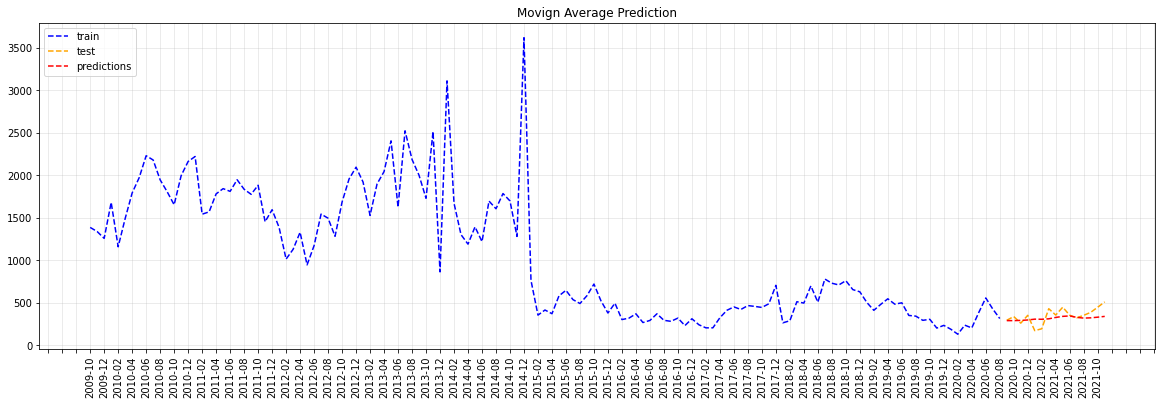

In [56]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:-len(test)], train, 'b--', label="train")
plt.plot(desembolso_time[-len(test):], test, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(test):], ma_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Movign Average Prediction")
plt.grid(alpha=0.3);

In [57]:
ma_mse = mse(test, ma_prediction)
ma_mse_sk = mean_squared_error(test, ma_prediction, squared=True)
ma_mae = mean_absolute_error(test, ma_prediction)
ma_r2 = r2_score(test, ma_prediction)
print(f'Mean Squared Error: {ma_mse} ', ma_mse_sk)
print(f'Mean Absolute Error: {ma_mae}')
print(f'R2 Score: {ma_r2}')

Mean Squared Error: 111665.47105199662  7444.364736799774
Mean Absolute Error: 69.25498146333332
R2 Score: 0.07216053724695337


---

## Exponencial
1. Suavização exponencial única - sem tendência ou sazonalidade
2. Suavização exponencial dupla - captura tendência
3. Suavização Exponencial Tripla - captura tendência e sazonalidade

### Exponencial Único

In [64]:
def predict_by_simple_exponential(observations):
    single_exp_model = SimpleExpSmoothing(observations).fit(optimized=True)
    single_preds = single_exp_model.forecast(1)
    return single_preds[0]

In [65]:
window_size: int = 12
test_size: int = 10 #em percentual

In [66]:
train, test, test_dataset = prepare_test_window_dataset(desembolso, test_size, window_size)

In [67]:
print(f'Tamanho da janela: {window_size}')
print(f'Tamanho total dataset: {len(desembolso)}')
print('Tamanho dataset treino:', len(train))
print('Tamanho dataset teste:', len(test))
print(f'Shape dados para previsão {test_dataset.shape}')

Tamanho da janela: 12
Tamanho total dataset: 146
Tamanho dataset treino: 131
Tamanho dataset teste: 15
Shape dados para previsão (15, 12)


In [68]:
single_exp_prediction_list:List = []
for t_index in range(len(test)):
    single_exp_prediction_list.append(predict_by_simple_exponential(test_dataset[t_index]))
single_exp_predicition = np.array(single_exp_prediction_list)

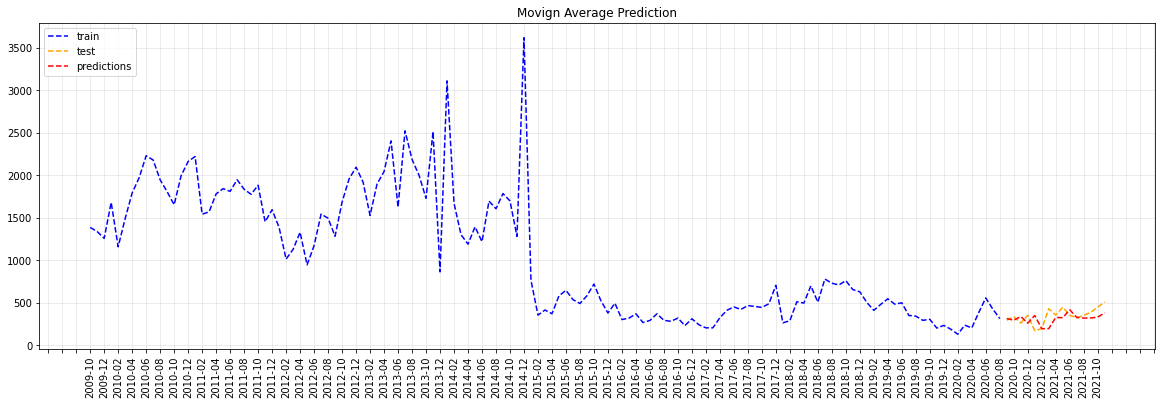

In [69]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:-len(test)], train, 'b--', label="train")
plt.plot(desembolso_time[-len(test):], test, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(test):], single_exp_predicition, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Movign Average Prediction")
plt.grid(alpha=0.3);

In [70]:
single_exp_mse = mse(test, single_exp_predicition)
single_exp_mse_sk = mean_squared_error(test, single_exp_predicition, squared=True)
single_exp_mae = mean_absolute_error(test, single_exp_predicition)
single_exp_r2 = r2_score(test, single_exp_predicition)
print(f'Mean Squared Error: {single_exp_mse} ', single_exp_mse_sk)
print(f'Mean Absolute Error: {single_exp_mae}')
print(f'R2 Score: {single_exp_r2}')

Mean Squared Error: 158961.55782470788  10597.43718831386
Mean Absolute Error: 80.73071045066844
R2 Score: -0.32082733382986195


---

### Exponencial Duplo

In [71]:
def predict_by_double_exponential(observations):
    double_exp_model = Holt(observations).fit(optimized=True)
    double_preds = double_exp_model.forecast(1)
    return double_preds[0]

In [72]:
window_size: int = 12
test_size: int = 10 #em percentual

In [73]:
train, test, test_dataset = prepare_test_window_dataset(desembolso, test_size, window_size)

In [74]:
print(f'Tamanho da janela: {window_size}')
print(f'Tamanho total dataset: {len(desembolso)}')
print('Tamanho dataset treino:', len(train))
print('Tamanho dataset teste:', len(test))
print(f'Shape dados para previsão {test_dataset.shape}')

Tamanho da janela: 12
Tamanho total dataset: 146
Tamanho dataset treino: 131
Tamanho dataset teste: 15
Shape dados para previsão (15, 12)


In [76]:
double_exp_prediction_list:List = []
for t_index in range(len(test)):
    double_exp_prediction_list.append(predict_by_double_exponential(test_dataset[t_index]))
double_exp_predicition = np.array(double_exp_prediction_list)

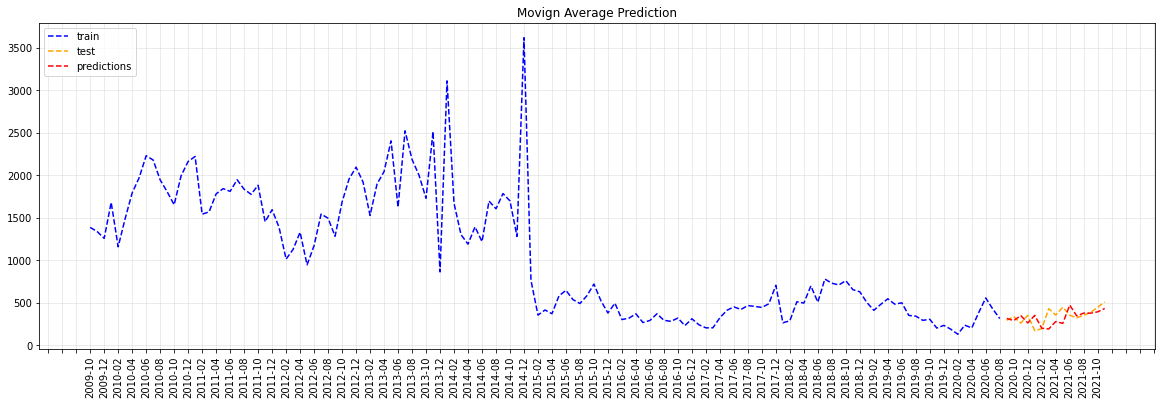

In [77]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:-len(test)], train, 'b--', label="train")
plt.plot(desembolso_time[-len(test):], test, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(test):], double_exp_predicition, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Movign Average Prediction")
plt.grid(alpha=0.3);

In [78]:
double_exp_mse = mse(test, double_exp_predicition)
double_exp_mse_sk = mean_squared_error(test, double_exp_predicition, squared=True)
double_exp_mae = mean_absolute_error(test, double_exp_predicition)
double_exp_r2 = r2_score(test, double_exp_predicition)
print(f'Mean Squared Error: {double_exp_mse} ', double_exp_mse_sk)
print(f'Mean Absolute Error: {double_exp_mae}')
print(f'R2 Score: {double_exp_r2}')

Mean Squared Error: 174397.08701470017  11626.472467646678
Mean Absolute Error: 83.18699644806811
R2 Score: -0.44908267521719725


---

### Exponencial Triplo (implementando)

In [6]:
def predict_by_triple_exponential(observations):
    triple_exp_model = ExponentialSmoothing(observations,
                              trend="multiplicative",
                              seasonal="multiplicative",
                              seasonal_periods=12).fit(optimized=True)
    triple_preds = triple_exp_model.forecast(1)
    return triple_preds[0]

In [7]:
window_size: int = 48
test_size: int = 10 #em percentual

In [8]:
train, test, test_dataset = prepare_test_window_dataset(desembolso, test_size, window_size)

In [9]:
print(f'Tamanho da janela: {window_size}')
print(f'Tamanho total dataset: {len(desembolso)}')
print('Tamanho dataset treino:', len(train))
print('Tamanho dataset teste:', len(test))
print(f'Shape dados para previsão {test_dataset.shape}')

Tamanho da janela: 48
Tamanho total dataset: 146
Tamanho dataset treino: 131
Tamanho dataset teste: 15
Shape dados para previsão (15, 48)


In [10]:
triple_exp_prediction_list:List = []
for t_index in range(len(test)):
    triple_exp_prediction_list.append(predict_by_triple_exponential(test_dataset[t_index]))
triple_exp_predicition = np.array(triple_exp_prediction_list)

C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

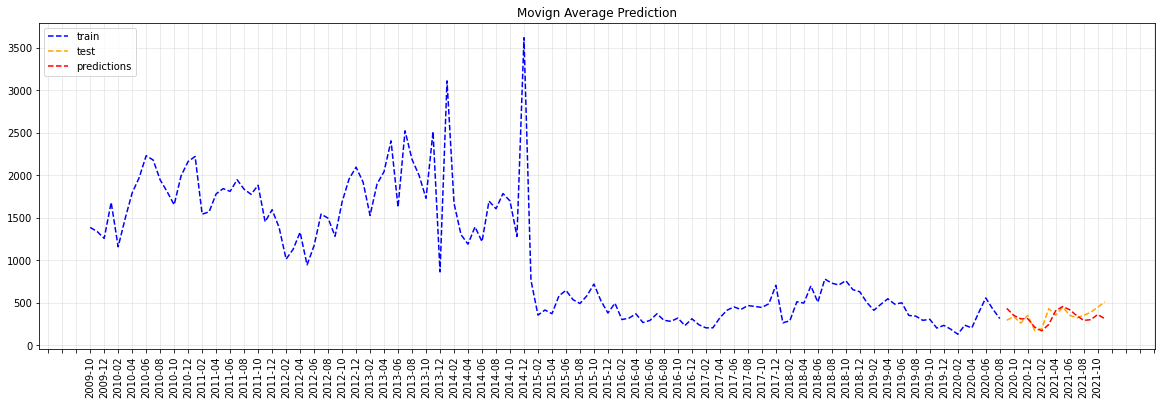

In [11]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:-len(test)], train, 'b--', label="train")
plt.plot(desembolso_time[-len(test):], test, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(test):], triple_exp_predicition, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Movign Average Prediction")
plt.grid(alpha=0.3);

In [13]:
triple_exp_mse = mse(test, triple_exp_predicition)
triple_exp_mse_sk = mean_squared_error(test, triple_exp_predicition, squared=True)
triple_exp_mae = mean_absolute_error(test, triple_exp_predicition)
triple_exp_r2 = r2_score(test, triple_exp_predicition)
print(f'Mean Squared Error: {triple_exp_mse} ', triple_exp_mse_sk)
print(f'Mean Absolute Error: {triple_exp_mae}')
print(f'R2 Score: {triple_exp_r2}')

Mean Squared Error: 124728.16996752904  8315.211331168603
Mean Absolute Error: 71.36988096367271
R2 Score: -0.0363787222905696


---
## AUTOREGRESSIVE MODELS